# Parametros

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from IPython.display import Audio
# Parámetros del sistema
FS = 48000          # Hz
FC = 4000           # Hz
BITS_PER_SYMBOL = 3
SPS = 128           # Samples per symbol
BETA = 0.35
SPAN = 8            # Duración filtro RRC en símbolos

# Símbolos por segundo resultantes:
RS = FS // SPS      # = 48000/128 = 375 sps


# Funciones del transmisor utiles

In [4]:
def rrc_filter(beta, span, sps):
    """
    Genera los coeficientes de un filtro Raised-Cosine Raíz (RRC/SRRC).

    Parámetros:
        beta : float
            Roll-off del filtro (0 < beta <= 1).
        span : int
            Duración del filtro en número de símbolos (ej: 6, 8, 10).
        sps : int
            Muestras por símbolo (Samples Per Symbol).

    Retorna:
        h : ndarray de floats, shape (span*sps + 1,)
            Coeficientes del filtro RRC.
    """
    N = span * sps
    t = np.arange(-N/2, N/2 + 1) / sps  # tiempo en unidades de T_símbolo

    h = np.zeros_like(t, dtype=float)
    for i, ti in enumerate(t):
        if np.isclose(ti, 0.0):
            h[i] = 1.0 - beta + (4 * beta / np.pi)
        elif np.isclose(abs(ti), 1/(4*beta)):
            # punto singular tratado aparte
            h[i] = (beta/np.sqrt(2)) * (
                ((1 + 2/np.pi) * np.sin(np.pi/(4*beta))) +
                ((1 - 2/np.pi) * np.cos(np.pi/(4*beta)))
            )
        else:
            num = np.sin(np.pi * ti * (1 - beta)) + \
                  4 * beta * ti * np.cos(np.pi * ti * (1 + beta))
            den = np.pi * ti * (1 - (4 * beta * ti)**2)
            h[i] = num / den

    # Normalizar energía (opcional pero recomendable)
    h = h / np.sqrt(np.sum(h**2))
    return h

def upsample_symbols(symbols, sps):
    """
    Sobremuestrea los símbolos insertando (sps-1) ceros entre ellos.

    Parámetros:
        symbols : ndarray complejo, shape (N_symbols,)
        sps : int
            Muestras por símbolo.

    Retorna:
        x_upsampled : ndarray complejo, shape (N_symbols * sps,)
    """
    n = len(symbols)
    x_upsampled = np.zeros(n * sps, dtype=complex)
    x_upsampled[::sps] = symbols
    return x_upsampled
def bits_to_rrc_waveform(bits, beta, span, sps):
    """
    Convierte bits → símbolos 8PSK → sobremuestreo → filtrado RRC,
    obteniendo la señal en banda base con pulso SRRC.

    Parámetros:
        bits : ndarray de enteros (0/1)
        beta : float
        span : int
        sps : int

    Retorna:
        tx_bb : ndarray complejo
            Señal en banda base (I + jQ) filtrada con RRC.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado.
        symbols : ndarray complejo
            Símbolos 8PSK antes del filtrado (para depuración).
    """
    # 1) bits → símbolos 8PSK
    symbols = bits_to_symbols_8psk(bits)

    # 2) diseñar filtro RRC
    rrc_taps = rrc_filter(beta, span, sps)

    # 3) sobremuestrear símbolos
    x_up = upsample_symbols(symbols, sps)

    # 4) filtrar (pulso con coseno levantado)
    tx_bb = np.convolve(x_up, rrc_taps, mode='full')

    return tx_bb, rrc_taps, symbols

def bits_to_symbols_8psk(bits):
    """
    Mapea una secuencia de bits a símbolos 8PSK sobre el círculo unitario.
    Usa agrupación de 3 bits por símbolo con mapeo Gray sencillo.

    Parámetros:
        bits : ndarray de enteros (0/1), shape (N,)

    Retorna:
        symbols : ndarray complejo, shape (N_symbols,)
            Símbolos 8PSK en el círculo unitario.
    """
    # Asegurar que la longitud sea múltiplo de 3
    n_triples = len(bits) // 3
    bits = bits[:3 * n_triples]
    bits_reshaped = bits.reshape(-1, 3)

    # Convertir cada grupo de 3 bits a un índice 0..7
    indices = bits_reshaped[:, 0] * 4 + bits_reshaped[:, 1] * 2 + bits_reshaped[:, 2] * 1

    # Mapeo Gray opcional (puedes ajustar si quieres otro mapa)
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])  # ejemplo
    gray_indices = gray_map[indices]

    # Fase para cada símbolo (8PSK → 8 fases uniformes)
    phases = 2 * np.pi * gray_indices / 8.0

    # Símbolos complejos en el círculo unitario
    symbols = np.exp(1j * phases)
    return symbols
def generate_carrier(fc, fs, n_samples):
    """
    Genera una portadora compleja e^{j2πf_c t}.

    Parámetros:
        fc : float
            Frecuencia de la portadora en Hz.
        fs : float
            Frecuencia de muestreo.
        n_samples : int
            Número de muestras a generar.

    Retorna:
        carrier : ndarray complejo de shape (n_samples,)
    """
    t = np.arange(n_samples) / fs
    carrier = np.exp(1j * 2 * np.pi * fc * t)
    return carrier
def modulate_to_passband(tx_bb, fc, fs):
    """
    Modula una señal de banda base (compleja) hacia banda pasante real para audio.

    Parámetros:
        tx_bb : ndarray complejo
            Señal en banda base (SRRC) I+jQ.
        fc : float
            Frecuencia de portadora en Hz.
        fs : float
            Frecuencia de muestreo en Hz.

    Retorna:
        tx_audio : ndarray float
            Señal real modulada lista para reproducir como audio.
    """
    n_samples = len(tx_bb)
    carrier = generate_carrier(fc, fs, n_samples)
    
    # Multiplicación complejo × complejo → señal analógica compleja
    tx_passband_complex = tx_bb * carrier
    
    # Sacar parte real → audio físico
    tx_audio = np.real(tx_passband_complex)

    # Normalizar para evitar clipping
    tx_audio /= np.max(np.abs(tx_audio) + 1e-12)

    return tx_audio
def downconvert_to_baseband(rx_audio, fc, fs):
    """
    Convierte una señal real en banda pasante a banda base compleja.

    Parámetros:
        rx_audio : ndarray float
            Señal de audio recibida (real).
        fc : float
            Frecuencia de portadora (Hz).
        fs : float
            Frecuencia de muestreo (Hz).

    Retorna:
        rx_bb : ndarray complejo
            Señal en banda base (I + jQ).
    """
    n = len(rx_audio)
    t = np.arange(n) / fs
    carrier = np.exp(-1j * 2 * np.pi * fc * t)
    rx_bb = rx_audio * carrier
    return rx_bb
def sample_symbols_after_rrc(z, rrc_taps, sps, n_symbols=None):
    """
    Toma las muestras en los instantes de símbolo a la salida
    del filtro casado (RRC en RX).

    Parámetros:
        z : ndarray complejo
            Señal filtrada (matched filter output).
        rrc_taps : ndarray float
        sps : int
            Muestras por símbolo.
        n_symbols : int o None
            Cantidad de símbolos a extraer. Si es None, se toma todo lo posible.

    Retorna:
        symbols_rx : ndarray complejo
            Símbolos muestreados.
    """
    total_delay = len(rrc_taps) - 1
    start = total_delay

    symbols_rx = z[start::sps]

    if n_symbols is not None:
        symbols_rx = symbols_rx[:n_symbols]

    return symbols_rx

def symbols_8psk_to_bits(symbols):
    """
    Convierte símbolos 8PSK (complejos) a bits usando
    el mismo mapeo Gray que en el transmisor.

    Parámetros:
        symbols : ndarray complejo

    Retorna:
        bits_rx : ndarray int (0/1)
    """
    # Fase entre 0 y 2π
    phases = np.angle(symbols)
    phases = (phases + 2 * np.pi) % (2 * np.pi)

    # Índices 0..7 según la fase
    indices_hat = np.round(phases * 8 / (2 * np.pi)).astype(int) % 8

    # Mismo Gray map que en TX
    gray_map = np.array([0, 1, 3, 2, 6, 7, 5, 4])

    # Inversa del Gray map
    inv_gray = np.zeros_like(gray_map)
    inv_gray[gray_map] = np.arange(8)

    m = inv_gray[indices_hat]  # índices binarios 0..7

    # Convertir índices a 3 bits (b2 b1 b0)
    b2 = (m >> 2) & 1
    b1 = (m >> 1) & 1
    b0 = m & 1

    bits_rx = np.column_stack((b2, b1, b0)).reshape(-1).astype(int)
    return bits_rx
def matched_filter(rx_bb, rrc_taps):
    """
    Aplica el filtro casado (mismo RRC que en TX).

    Parámetros:
        rx_bb : ndarray complejo
            Señal en banda base después de downconversion.
        rrc_taps : ndarray float
            Coeficientes del filtro RRC usado en el TX.

    Retorna:
        z : ndarray complejo
            Señal filtrada (salida del filtro casado).
    """
    z = np.convolve(rx_bb, rrc_taps, mode='full')
    return z

def quick_demod_8psk(rx_audio, fc, fs, rrc_taps, sps, n_symbols=None):
    """
    Demodulador rápido para prueba en lazo cerrado (ideal):
    - Downconversion
    - Matched filter (RRC)
    - Muestreo por símbolo
    - Decisión 8PSK → bits

    Parámetros:
        rx_audio : ndarray float
            Señal de audio recibida (real).
        fc : float
            Frecuencia de portadora.
        fs : float
            Frecuencia de muestreo.
        rrc_taps : ndarray float
        sps : int
        n_symbols : int o None
            Número de símbolos esperados (si se conoce).

    Retorna:
        bits_rx : ndarray int
            Bits recuperados.
        symbols_rx : ndarray complejo
            Símbolos detectados antes de decisión.
    """
    # 1. Banda base
    rx_bb = downconvert_to_baseband(rx_audio, fc, fs)

    # 2. Filtro casado
    z = matched_filter(rx_bb, rrc_taps)

    # 3. Muestreo
    symbols_rx = sample_symbols_after_rrc(z, rrc_taps, sps, n_symbols=n_symbols)

    # 4. Decisión a bits
    bits_rx = symbols_8psk_to_bits(symbols_rx)

    return bits_rx, symbols_rx

In [9]:
def record_and_receive_8psk(
    fs=48000,
    max_duration=10.0
):

    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    # Señal cruda tal cual la entregó el micrófono
    rx = recording[:, 0]

    # ===== 0. GRAFICAR SEÑAL CRUDA =====
    t_full = np.arange(len(rx)) / fs

    plt.figure(figsize=(10,4))
    plt.plot(t_full, rx, linewidth=0.8)
    plt.title("Señal recibida cruda desde el micrófono")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()


    return t_full, rx,



In [3]:
def detect_signal_start(rx, fs, threshold=0.02, min_silence=0.2):
    """
    Detecta aproximádamente dónde empieza la señal útil,
    usando un umbral de amplitud.

    Parámetros:
        rx : ndarray float
            Señal de audio grabada.
        fs : int
            Frecuencia de muestreo.
        threshold : float
            Umbral de amplitud para considerar que 'hay señal'.
        min_silence : float
            Tiempo mínimo inicial sin señal (s) para evitar falsos disparos.

    Retorna:
        start_idx : int
            Índice aproximado donde empieza la señal.
    """
    n_min = int(min_silence * fs)
    rx_abs = np.abs(rx)

    # Buscar desde n_min hacia adelante
    for i in range(n_min, len(rx_abs)):
        if rx_abs[i] > threshold:
            return i

    # Si no encuentra nada, devolvemos 0
    return 0
# Ejemplo de uso:
start_idx = detect_signal_start(rx, fs=FS)
print(f"Índice aproximado de inicio de señal: {start_idx} (tiempo: {start_idx/FS:.2f} s)")

Índice aproximado de inicio de señal: 201181 (tiempo: 4.19 s)


# Detectar y demodular

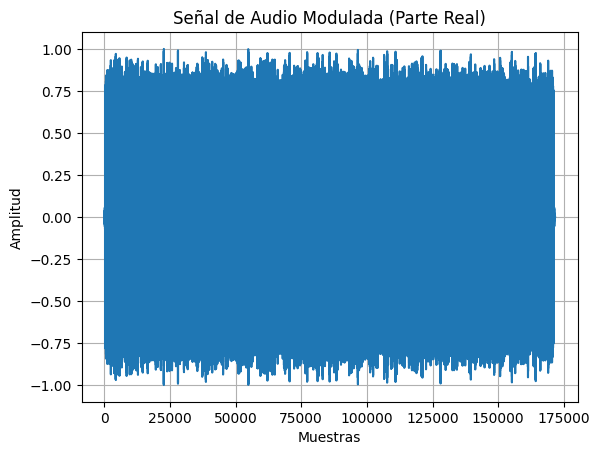

In [23]:
def generate_bits(n_bits, rng=None):
    """
    Genera una secuencia de bits aleatorios (0/1).

    Parámetros:
        n_bits : int
            Número de bits a generar.
        rng : np.random.Generator o None
            Generador aleatorio. Si es None, se crea uno nuevo.

    Retorna:
        bits : ndarray de shape (n_bits,)
            Arreglo de bits 0/1 (dtype=int).
    """
    if rng is None:
        rng = np.random.default_rng()
    bits = rng.integers(0, 2, size=n_bits, dtype=int)
    return bits

def play_audio(signal, fs):
    """
    Muestra un reproductor de audio para la señal dada.

    Parámetros:
        signal : ndarray float
        fs : int
            Frecuencia de muestreo.
    """
    return Audio(signal.astype(np.float32), rate=fs)


# --- 1. Generar bits ---
bits = generate_bits(4000)

# --- 2. Bits → señal SRRC en banda base ---
tx_bb, rrc_taps, symbols = bits_to_rrc_waveform(
    bits,
    beta=BETA,
    span=SPAN,
    sps=SPS
)

# --- 3. Modulación a banda pasante ---
fc = 4000     # Frecuencia de portadora en Hz (tú la puedes cambiar)
tx_audio = modulate_to_passband(tx_bb, fc, FS)
# --- 4. Graficar señal modulada ---
plt.figure()
plt.plot(tx_audio)
plt.title("Señal de Audio Modulada (Parte Real)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid()
plt.show()
# --- 5. Reproducir audio ---
play_audio(tx_audio, FS)


🎙 Grabando desde el micrófono por máximo 6.0 s...
✔ Grabación finalizada.


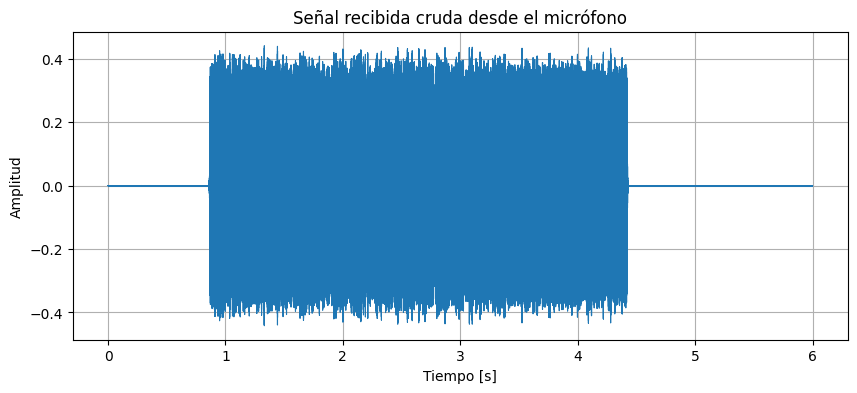

Inicio estimado de la señal en muestra: 41407 → tiempo aprox: 0.8626458333333333 s


In [51]:
def receive_and_demod_8psk(
    fs,
    fc,
    max_duration,
    rrc_taps,
    sps,
    n_symbols_esperados
):
    # 1. Grabar
    t_full, rx = record_and_receive_8psk(
        fs=fs,
        max_duration=max_duration
    )

    # 2. Detectar inicio aproximado de la señal
    start_idx = detect_signal_start(rx, fs, threshold=0.02, min_silence=0.1)
    print("Inicio estimado de la señal en muestra:", start_idx,
          "→ tiempo aprox:", start_idx/fs, "s")

    # 3. Recortar desde ese punto
    rx_cut = rx[start_idx:]

    # 4. Bajar a banda base
    rx_bb = downconvert_to_baseband(rx_cut, fc, fs)

    # 5. Filtro casado RRC
    z = matched_filter(rx_bb, rrc_taps)

    # 6. Muestreo de símbolos
    symbols_rx = sample_symbols_after_rrc(
        z,
        rrc_taps,
        sps,
        n_symbols=n_symbols_esperados
    )

    # 7. Decisión 8PSK → bits
    bits_rx = symbols_8psk_to_bits(symbols_rx)

    return bits_rx, symbols_rx, rx, t_full
FS = 48000
FC = 4000
SPS = 128
BETA = 0.35
SPAN = 8

# En el receptor debes recrear el mismo filtro RRC:
rrc_taps_rx = rrc_filter(BETA, SPAN, SPS)

# Debes conocer cuántos símbolos esperas (los mismos que enviaste):
n_bits_tx = 4000          # o los que uses
n_symbols_esperados = n_bits_tx // 3   # cuidado con redondeo

bits_rx, symbols_rx, rx_raw, t_full = receive_and_demod_8psk(
    fs=FS,
    fc=FC,
    max_duration=6.0,          # un poco más de lo que dura el mensaje
    rrc_taps=rrc_taps_rx,
    sps=SPS,
    n_symbols_esperados=n_symbols_esperados
)


In [52]:
# Recorta desde el inicio detectado
rx_cut = rx_raw[start_idx:]

# Downconvert
rx_bb = downconvert_to_baseband(rx_cut, FC, FS)

# Matched filter
z = matched_filter(rx_bb, rrc_taps_rx)

# Símbolos
symbols_rx = sample_symbols_after_rrc(
    z,
    rrc_taps_rx,
    SPS,
    n_symbols=n_symbols_esperados
)

# Bits
ber = np.mean(bits_rx!= bits[:len(bits_rx)] )
print("BER =", ber)


BER = 0.5046261565391348


In [53]:
def find_best_symbol_offset(z, rrc_taps, sps, n_symbols, bits_tx, search=50):
    """
    Busca el mejor offset para muestrear los símbolos probando 
    varias posiciones alrededor del inicio nominal.

    Parámetros:
        z : señal filtrada
        rrc_taps : filtros RRC
        sps : samples per symbol
        n_symbols : cantidad de símbolos esperados
        bits_tx : bits transmitidos (para calcular BER)
        search : número de muestras hacia adelante y atrás a probar

    Retorna:
        best_offset : int
        best_ber : float
    """
    delay = len(rrc_taps) - 1
    best_offset = 0
    best_ber = 1.0

    for off in range(-search, search+1):
        idx = delay + off
        if idx < 0:
            continue

        symbols_rx = z[idx::sps][:n_symbols]
        bits_rx = symbols_8psk_to_bits(symbols_rx)

        n = min(len(bits_tx), len(bits_rx))
        ber = np.mean(bits_tx[:n] != bits_rx[:n])

        if ber < best_ber:
            best_ber = ber
            best_offset = off

    return best_offset, best_ber
best_offset, best_ber = find_best_symbol_offset(
    z,
    rrc_taps_rx,
    SPS,
    n_symbols_esperados,
    bits,  # los bits originales
    search=60
)

print("Mejor offset:", best_offset)
print("BER óptimo:", best_ber)


Mejor offset: 15
BER óptimo: 0.49288168875797744


(np.float64(-1.890589530002417),
 np.float64(1.8349152044352937),
 np.float64(-1.8455341991133176),
 np.float64(1.800946097755717))

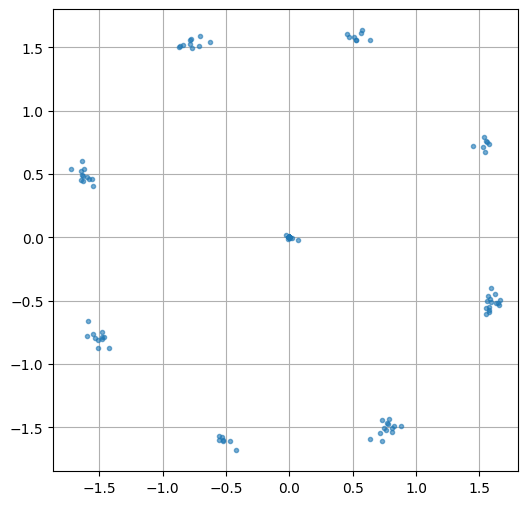

In [54]:
plt.figure(figsize=(6,6))
plt.plot(symbols_rx.real, symbols_rx.imag, '.', alpha=0.6)
plt.grid(True)
plt.axis('equal')


In [71]:
def find_best_symbol_shift(bits_tx, bits_rx, max_shift_symbols=50):
    """
    Busca el mejor corrimiento entero de símbolos (en TX o RX)
    que minimiza el BER. Útil para depurar problemas de alineación.

    bits_tx : bits originales transmitidos
    bits_rx : bits recuperados
    max_shift_symbols : cuántos símbolos hacia adelante/atrás probar

    Retorna:
        best_shift_symbols : corrimiento en símbolos (positivo = RX atrasado)
        best_ber : BER mínimo encontrado
    """
    BPS = 3  # bits por símbolo en 8PSK
    best_ber = 1.0
    best_shift = 0

    for shift_sym in range(-max_shift_symbols, max_shift_symbols + 1):
        shift_bits = shift_sym * BPS

        if shift_bits >= 0:
            tx_seg = bits_tx[:len(bits_rx) - shift_bits]
            rx_seg = bits_rx[shift_bits:shift_bits + len(tx_seg)]
        else:
            # shift_bits negativo: corremos TX hacia adelante
            sb = -shift_bits
            tx_seg = bits_tx[sb:sb + len(bits_rx)]
            rx_seg = bits_rx[:len(tx_seg)]

        if len(tx_seg) == 0 or len(rx_seg) == 0:
            continue

        ber = np.mean(tx_seg != rx_seg)
        if ber < best_ber:
            best_ber = ber
            best_shift = shift_sym

    return best_shift, best_ber
best_shift_sym, best_ber = find_best_symbol_shift(bits, bits_rx, max_shift_symbols=100)
print("Mejor corrimiento en símbolos:", best_shift_sym)
print("BER mínimo encontrado:", best_ber)


Mejor corrimiento en símbolos: 1
BER mínimo encontrado: 0.4759095378564405
